##  K-means no GBP/USD
 

#### Etapas


- Passo 1 - Carregar as bibliotecas
- Passo 2 - Carregar a base de dados
- Passo 3 - Tratamento dos dados
- Passo 4 - Construçao dos alvos e variaveis
- Passo 5 - Preparaçao da base para treinamento e teste
- Passo 6 - Avaliaçao dos numeros de clusters necessàrios
- Passo 7 - Avaliaçao dos Resultados
- Passo 8 - Analise bivariada
- Passo 9 - Retreinamento do K-means
- Passo 10 - Re-avaliaçao dos Resultados

 

________________________________________________________

### Passo 1 - Carregando as bibliotecas


In [198]:
import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, precision_recall_curve, auc, make_scorer, recall_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [199]:
# Para remover os warnings

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

----------------

### Passo 2 - Carregando a base de dados

In [294]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
import os
os.chdir("E:\\Base de Dados")

df1 = pd.read_csv("GBPUSD1.csv", sep = ",")

df1.shape[0]

7447

In [295]:
df1.head()

,1993.05.12,00:00,1.53700,1.54450,1.52900,1.53380,2781
0,1993.05.13,00:00,1.5328,1.5360,1.5180,1.5225,2571
1,1993.05.14,00:00,1.5228,1.5415,1.5200,1.5387,2711
2,1993.05.17,00:00,1.5365,1.5460,1.5309,1.5355,2921
3,1993.05.18,00:00,1.5350,1.5380,1.5237,1.5365,2711
4,1993.05.19,00:00,1.5350,1.5482,1.5328,1.5432,2261


---------
### Passo 3 - Tratamento dos dados


In [296]:
# Ajustando a data e o nome das colunas

df1 = df1.rename(columns={"1993.05.12" :"data", "00:00" : "hora", "1.53700": "open", "1.54450" : "high", "1.52900" : "low", "1.53380" : "close", "2781" : "volume"})

df1["data"] = pd.to_datetime(df1["data"]).dt.normalize()

df1 = df1.set_index("data")

In [297]:
df1 = df1.drop(["hora"], axis= 1)

In [298]:
df1.head()

,open,high,low,close,volume
data,,,,,
1993-05-13,1.5328,1.5360,1.5180,1.5225,2571
1993-05-14,1.5228,1.5415,1.5200,1.5387,2711
1993-05-17,1.5365,1.5460,1.5309,1.5355,2921
1993-05-18,1.5350,1.5380,1.5237,1.5365,2711
1993-05-19,1.5350,1.5482,1.5328,1.5432,2261


In [299]:
df1.describe()

,open,high,low,close,volume
count,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000
mean,1.566980,1.573692,1.560305,1.567149,41829.085269
std,0.189011,0.189434,0.188425,0.188992,45756.469295
min,1.146520,1.171350,1.140980,1.146530,78.000000
25%,1.442900,1.448950,1.435550,1.442850,7583.000000
50%,1.565500,1.572100,1.559900,1.566000,13571.000000
75%,1.647325,1.655020,1.639800,1.647480,71365.500000
max,2.106800,2.116100,2.098300,2.106500,358974.000000


-----------------------------------------------------------------------


### PCA

-------------

### Passo 4 - Construção dos alvos e variaveis

In [300]:
# Construção dos alvos

periodos = 2

#lag de x periodos
df1["Lag1"] = df1["close"].shift(-periodos)

# Alvo 1 - Retorno
df1["retorno"] = df1["close"].pct_change(periodos)
df1["Alvo1"] = df1["retorno"].shift(-periodos)

# Variação em pontos do alvo
df1["pips"] =(df1["close"] - df1["close"].shift(1))
df1["pips"] = df1["pips"].shift(-periodos) 



In [301]:
df1.describe()

,open,high,low,close,volume,Lag1,retorno,Alvo1,pips
count,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000,7445.000000,7445.000000,7445.000000,7445.000000
mean,1.566980,1.573692,1.560305,1.567149,41829.085269,1.567159,-0.000011,-0.000011,-0.000031
std,0.189011,0.189434,0.188425,0.188992,45756.469295,0.189016,0.007907,0.007907,0.008746
min,1.146520,1.171350,1.140980,1.146530,78.000000,1.146530,-0.110655,-0.110655,-0.124020
25%,1.442900,1.448950,1.435550,1.442850,7583.000000,1.442800,-0.004425,-0.004425,-0.004800
50%,1.565500,1.572100,1.559900,1.566000,13571.000000,1.566000,0.000024,0.000024,0.000000
75%,1.647325,1.655020,1.639800,1.647480,71365.500000,1.647500,0.004563,0.004563,0.004800
max,2.106800,2.116100,2.098300,2.106500,358974.000000,2.106500,0.053299,0.053299,0.049100


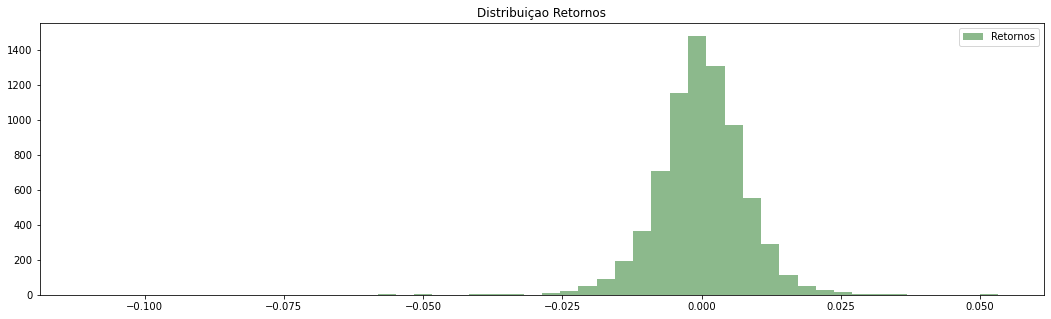

In [302]:
# Distribuição dos retornos

plt.figure(figsize = (18,5))
plt.hist(df1["retorno"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [303]:
# Criação do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > df1["retorno"].describe()[6]/2, 1
                            , np.where(df1['Alvo1'] < df1["retorno"].describe()[4]/2, -1, 0))

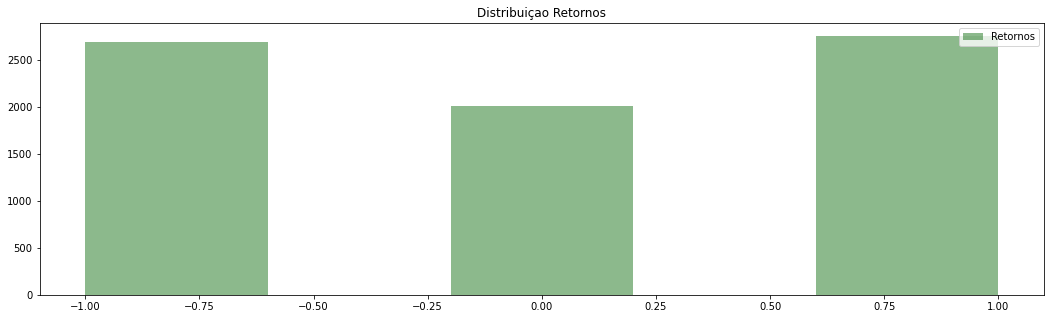

In [304]:
plt.figure(figsize = (18,5))
plt.hist(df1["Alvo_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [305]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1['close'] > df1['open'] , 1, 0)

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Aplicando a fisica

p = 2 

# Velocidade de p dias
df1["v"] = (df1["retorno"] - df1["retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]


# Trabalho 
# cateto_oposto
cat_op = df1["retorno"].rolling(p).sum()-df1["retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["retorno"].rolling(p).sum()/(df1["m"]/df1["retorno"].rolling(p).sum())*(df1["m"]/df1["retorno"].rolling(p).sum())

df1.head(10)

,open,high,low,close,volume,Lag1,retorno,Alvo1,pips,Alvo_Bin,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
1993-06-24,1.4720,1.4761,1.4637,1.4690,2181,1.4959,-0.005955,0.018312,0.0197,1,...,0.003645,-0.016032,-0.000058,-1.039010e-07,-0.005039,-0.000058,0.000162,2.944297e-07,-0.000058,NaN
1993-06-25,1.4683,1.4835,1.4670,1.4762,2511,1.5123,0.001832,0.024455,0.0164,1,...,0.001286,-0.004122,-0.000005,-7.309025e-08,-0.002977,-0.000005,0.000025,1.578470e-08,-0.000025,0.000017
1993-06-28,1.4785,1.4975,1.4750,1.4959,2761,1.4908,0.018312,-0.003409,-0.0215,-1,...,0.004267,0.020144,0.000086,1.482777e-06,0.000916,0.000086,0.000037,7.874210e-08,0.000244,0.000406
1993-06-29,1.4954,1.5155,1.4894,1.5123,3531,1.5150,0.024455,0.001785,0.0242,0,...,0.002678,0.042766,0.000115,2.735818e-06,0.009156,0.000115,0.000783,1.048633e-06,0.000484,0.001829
1993-06-30,1.5120,1.5135,1.4885,1.4908,2881,1.5070,-0.003409,0.010867,-0.0080,1,...,-0.011497,0.021045,-0.000242,1.241166e-06,0.012227,-0.000242,0.000515,-2.958267e-06,-0.000229,0.000443
1993-07-01,1.4898,1.5175,1.4867,1.5150,3641,1.5105,0.001785,-0.002970,0.0035,-1,...,-0.011323,-0.001624,0.000018,-1.043187e-07,-0.001705,0.000018,0.000006,-3.134512e-08,0.000018,0.000003
1993-07-02,1.5150,1.5255,1.5055,1.5070,3201,1.5040,0.010867,-0.001991,-0.0065,0,...,0.008999,0.012652,0.000114,3.223151e-07,0.000893,0.000114,0.000023,1.016394e-07,0.000090,0.000160
1993-07-05,1.5080,1.5145,1.5045,1.5105,1751,1.4955,-0.002970,-0.009930,-0.0085,-1,...,0.004478,0.007896,0.000035,2.232326e-08,0.005433,0.000035,0.000086,1.921366e-07,-0.000019,0.000062
1993-07-06,1.5095,1.5130,1.5015,1.5040,1751,1.4970,-0.001991,-0.004654,0.0015,-1,...,-0.006783,-0.004961,0.000034,-1.025140e-07,-0.001485,0.000034,0.000015,-4.997839e-08,0.000032,0.000025


In [306]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0) 

df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15", "volume"], axis = 1)

In [307]:
corte = 5

df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)

In [308]:
pd.crosstab(pd.qcut(df1["RSL_std10"], corte, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std10,,,
0,7.053270,5.421443,7.525287
1,7.322994,5.340526,7.336480
2,7.174646,5.111261,7.714093
3,7.242077,5.259609,7.498314
4,7.282535,5.785570,6.931895


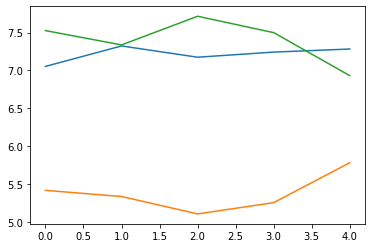

In [309]:
plt.plot(pd.crosstab(pd.qcut(df1["RSL_std10"], corte, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100);

In [310]:
df1_filtrado.tail()

,open,high,low,close,Lag1,retorno,Alvo1,pips,Alvo_Bin,prop,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
2022-03-30,1.30918,1.31823,1.30812,1.31322,1.31140,0.003715,-0.001386,-0.00195,0,0.399604,...,3,1,1,1,-0.003395,1,2,3,0,1
2022-03-31,1.31299,1.31751,1.31050,1.31335,1.31151,0.003208,-0.001401,0.00011,0,0.051355,...,4,3,3,4,0.001857,3,2,3,3,2
2022-04-01,1.31329,1.31510,1.30860,1.31140,1.30719,-0.001386,-0.003210,-0.00432,-1,-0.290769,...,0,2,1,3,0.001604,1,1,1,1,0
2022-04-04,1.30926,1.31367,1.30926,1.31151,1.30706,-0.001401,-0.003393,-0.00013,-1,0.510204,...,0,1,3,1,-0.000693,3,1,1,2,0
2022-04-05,1.31130,1.31665,1.30664,1.30719,1.30665,-0.003210,-0.000413,-0.00041,0,-0.410589,...,2,1,1,2,-0.000700,1,1,2,2,1


In [311]:
# Criação do alvo
df1_filtrado["Alvo_Bin"] = np.where(df1_filtrado['Alvo1'] > df1_filtrado["retorno"].describe()[6]/2, 1
                            , np.where(df1_filtrado['Alvo1'] < df1_filtrado["retorno"].describe()[4]/2, -1, 0))

In [312]:
df1_filtrado.head()

,open,high,low,close,Lag1,retorno,Alvo1,pips,Alvo_Bin,prop,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
1993-06-25,1.4683,1.4835,1.4670,1.4762,1.5123,0.001832,0.024455,0.0164,1,0.478788,...,3,1,1,0,-0.002977,1,2,3,0,1
1993-06-28,1.4785,1.4975,1.4750,1.4959,1.4908,0.018312,-0.003409,-0.0215,-1,0.773333,...,4,4,4,4,0.000916,4,2,4,4,4
1993-06-29,1.4954,1.5155,1.4894,1.5123,1.5150,0.024455,0.001785,0.0242,0,0.647510,...,3,4,4,4,0.009156,4,4,4,4,4
1993-06-30,1.5120,1.5135,1.4885,1.4908,1.5070,-0.003409,0.010867,-0.0080,1,-0.848000,...,0,4,0,4,0.012227,0,4,0,0,4
1993-07-01,1.4898,1.5175,1.4867,1.5150,1.5105,0.001785,-0.002970,0.0035,-1,0.818182,...,0,2,3,0,-0.001705,3,1,1,3,0


----------------

### Passo 5 - Preparação da base p/ treinamento e teste

In [313]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2005 à 2012
start_train = "1993-07-29"
end_train = "2006-12-31"

# Vamos testar o modelo de 2013 à 2020
start_test = "2007-01-01"
end_test = "2022-01-26"

df1_train1 = df1_filtrado.loc[start_train : end_train]

df1_test1 = df1_filtrado.loc[start_test : end_test]

In [314]:
df1.tail()

,open,high,low,close,volume,Lag1,retorno,Alvo1,pips,Alvo_Bin,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
2022-03-30,1.30918,1.31823,1.30812,1.31322,82928,1.31140,0.003715,-0.001386,-0.00195,0,...,0.003400,-0.003076,-0.000010,-5.086808e-08,-0.003395,-0.000010,0.000021,3.549630e-08,-0.000018,0.000009
2022-03-31,1.31299,1.31751,1.31050,1.31335,86498,1.31151,0.003208,-0.001401,0.00011,0,...,0.003777,0.006923,0.000026,8.650451e-08,0.001857,0.000026,0.000026,4.855947e-08,0.000035,0.000048
2022-04-01,1.31329,1.31510,1.30860,1.31140,75766,1.30719,-0.001386,-0.003210,-0.00432,-1,...,-0.004151,0.001822,-0.000008,5.925811e-09,0.001604,-0.000008,0.000006,-1.213341e-08,-0.000005,0.000003
2022-04-04,1.30926,1.31367,1.30926,1.31151,56600,1.30706,-0.001401,-0.003393,-0.00013,-1,...,-0.003652,-0.002787,0.000010,-7.400831e-09,-0.000693,0.000010,0.000004,-7.052454e-09,0.000006,0.000008
2022-04-05,1.31130,1.31665,1.30664,1.30719,63570,1.30665,-0.003210,-0.000413,-0.00041,0,...,0.000819,-0.004611,-0.000004,-1.918561e-09,-0.000700,-0.000004,0.000006,2.645608e-09,0.000004,0.000021


In [315]:
df1_test1.head()

,open,high,low,close,Lag1,retorno,Alvo1,pips,Alvo_Bin,prop,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
2007-01-02,1.9613,1.9741,1.9587,1.9732,1.9441,0.005350,-0.014748,-0.0064,-1,0.772727,...,1,3,1,2,0.000511,1,1,1,2,2
2007-01-03,1.9731,1.9750,1.9480,1.9505,1.9291,-0.004999,-0.010972,-0.0150,-1,-0.837037,...,1,2,2,2,0.002675,2,1,2,1,0
2007-01-04,1.9504,1.9529,1.9396,1.9441,1.9389,-0.014748,-0.002675,0.0098,-1,-0.473684,...,0,0,4,0,-0.002500,4,3,0,4,4
2007-01-05,1.9438,1.9441,1.9263,1.9291,1.9387,-0.010972,0.004976,-0.0002,1,-0.825843,...,2,0,2,0,-0.007374,2,4,2,4,4
2007-01-08,1.9303,1.9403,1.9260,1.9389,1.9326,-0.002675,-0.003249,-0.0061,-1,0.601399,...,4,0,0,0,-0.005486,0,4,4,0,3


In [316]:
df1_filtrado.columns[9:]

Index(['prop', 'dir_D', 'dir_D-1', 'dir_D-2', 'dir_D-3', 'RSL_std5',
       'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f', 'T', 'cat', 'w', 'k',
       'tau', 'M', 'g'],
      dtype='object')

In [317]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df1_train1.iloc[:, 9:df1_filtrado.shape[0]]
y_train1 = df1_train1['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:df1_filtrado.shape[0]]
y_test1 = df1_test1['Alvo_Bin'].values.reshape(-1, 1)

------------------------------------- 

### PCA

In [318]:
# Padronaziçao a base 

sc = StandardScaler()

x_train_pca = sc.fit_transform(x_train1)
x_test_pca = sc.transform(x_test1)

In [319]:
# Aplicando a PCA

pca = PCA(n_components = 2)
pcas = ["PC1", "PC2"]

x_train1_pca = pca.fit_transform(x_train1_pca)
x_test1_pca = pca.transform(x_test1_pca)

In [320]:
explained_variance = pca.explained_variance_ratio_

sum(explained_variance)

1.0

In [321]:
# Treinamento da arvore de decisao para a tarefa de classificaçao - reveja a aula de tarefas de data mining se preciso

from sklearn.tree import DecisionTreeClassifier

mod_arvore1 = DecisionTreeClassifier(criterion = "gini", max_depth = 10
                                     , min_samples_leaf = 50
                                     , min_samples_split = 5
                                     , max_leaf_nodes = 10)

mod_arvore1.fit(x_train1_pca, y_train1) # essa é a linha que treina o modelo!!!!

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=50,
                       min_samples_split=5)

In [322]:
# Prediçoes para o teste

y_pred_test1 = mod_arvore1.predict(x_test1_pca)

In [323]:
# Como availar os resultados?

print(confusion_matrix(y_test1, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1))

[[ 784  151  534]
 [ 309  162  511]
 [ 202  145 1114]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.61      0.53      0.57      1469
           0       0.35      0.16      0.23       982
           1       0.52      0.76      0.62      1461

    accuracy                           0.53      3912
   macro avg       0.49      0.49      0.47      3912
weighted avg       0.51      0.53      0.50      3912



In [324]:
# Acuràcia do modelo
import sklearn.metrics as metrics
print("Acuracia com PCA:", round(metrics.accuracy_score(y_test1, y_pred_test1)*100,3))

Acuracia com PCA: 52.658


In [325]:
# Calculando a performance

df1_test1.loc[: , "Previsto_PCA"] = y_pred_test1

In [326]:
df1_test1["Previsto_PCA"].astype(str)

data
2007-01-02    -1
2007-01-03     1
2007-01-04     1
2007-01-05     1
2007-01-08     0
              ..
2022-01-20    -1
2022-01-21    -1
2022-01-24     1
2022-01-25    -1
2022-01-26    -1
Name: Previsto_PCA, Length: 3912, dtype: object

In [328]:
# Ajustando o retorno em pips com o resultado do modelo

df1_test1.loc[: , "Ret_Pips_PCA"] = np.where(df1_test1.loc[: , 'Previsto_PCA'] == 1 , df1_test1.loc[: , 'pips'], '0')
df1_test1.loc[: , "Ret_Pips_PCA"] = np.where(df1_test1.loc[: , 'Previsto_PCA'] == 0 , -1*df1_test1.loc[: , 'pips'], df1_test1.loc[: , "Ret_Pips_PCA"])

In [329]:
# Convertendo para float

df1_test1.loc[: , "Ret_Pips_PCA"] = df1_test1["Ret_Pips_PCA"].astype(float)

In [330]:
df1_test1.loc[: , "Ret_Pips_PCA_Acumulado"] = df1_test1["Ret_Pips_PCA"].cumsum()

In [331]:
df1_test1.loc[: , "Ret_Pips_PCA_Acumulado"].tail()

data
2022-01-20    3.77750
2022-01-21    3.77750
2022-01-24    3.77397
2022-01-25    3.77397
2022-01-26    3.77397
Name: Ret_Pips_PCA_Acumulado, dtype: float64

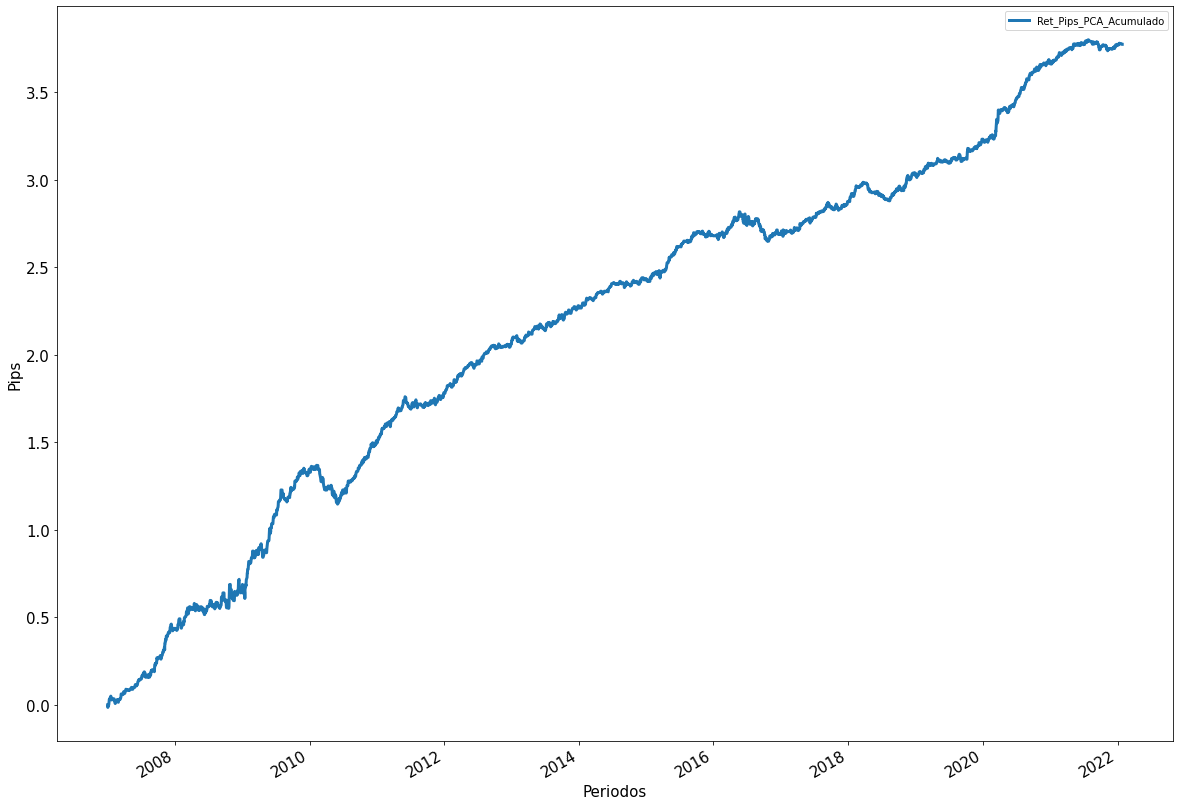

In [332]:
df1_test1["Ret_Pips_PCA_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel('Periodos'
           , fontsize = 15);
plt.ylabel('Pips'
           , fontsize = 15);
plt.legend()

In [338]:
df1_test1.loc[: , 'Resultado_Aleatorio'] = np.random.randint(0, 2, size = len(df1_test1)).astype(float)

df1_test1.loc[: , "Resultado_Aleatorio"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio'] == 1 , df1_test1.loc[: , 'pips'], '0')
df1_test1.loc[: , "Resultado_Aleatorio"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio'] == 0 , -1*df1_test1.loc[: , 'pips'], df1_test1.loc[: , "Resultado_Aleatorio"])

df1_test1.loc[: , "Resultado_Aleatorio"] = df1_test1["Resultado_Aleatorio"].astype(float).cumsum()

df1_test1.loc[: , 'Resultado_Aleatorio2'] = np.random.randint(0, 2, size = len(df1_test1)).astype(float)

df1_test1.loc[: , "Resultado_Aleatorio2"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio2'] == 1 , df1_test1.loc[: , 'pips'], '0')
df1_test1.loc[: , "Resultado_Aleatorio2"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio2'] == 0 , -1*df1_test1.loc[: , 'pips'], df1_test1.loc[: , "Resultado_Aleatorio2"])

df1_test1.loc[: , "Resultado_Aleatorio2"] = df1_test1["Resultado_Aleatorio2"].astype(float).cumsum()

In [339]:
df1_test1.loc[: , 'Resultado_Aleatorio'].tail()

data
2022-01-20   -0.49793
2022-01-21   -0.49714
2022-01-24   -0.49714
2022-01-25   -0.50482
2022-01-26   -0.50296
Name: Resultado_Aleatorio, dtype: float64

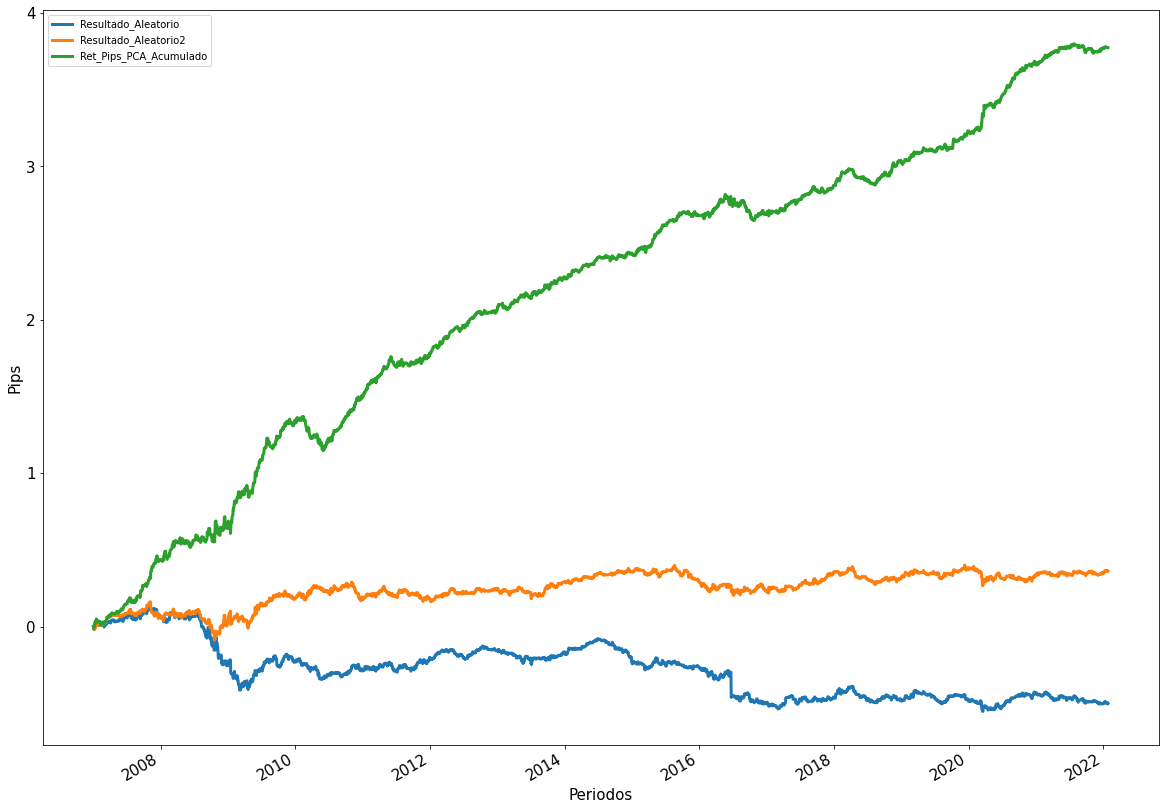

In [340]:
df1_test1["Resultado_Aleatorio"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
df1_test1["Resultado_Aleatorio2"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
#df1_test1["Ret_Pips_Sem_PCA_Acumulado"].plot(figsize=(20,15)
                                     #, linewidth = 3
                                     #, fontsize = 15)
df1_test1["Ret_Pips_PCA_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel('Periodos'
           , fontsize = 15);
plt.ylabel('Pips'
           , fontsize = 15);
plt.legend()

In [342]:
df1.head()

,open,high,low,close,volume,Lag1,retorno,Alvo1,pips,Alvo_Bin,...,a,m,f,T,cat,w,k,tau,M,g
data,,,,,,,,,,,,,,,,,,,,,
1993-06-24,1.4720,1.4761,1.4637,1.4690,2181,1.4959,-0.005955,0.018312,0.0197,1,...,0.003645,-0.016032,-0.000058,-1.039010e-07,-0.005039,-0.000058,0.000162,2.944297e-07,-0.000058,NaN
1993-06-25,1.4683,1.4835,1.4670,1.4762,2511,1.5123,0.001832,0.024455,0.0164,1,...,0.001286,-0.004122,-0.000005,-7.309025e-08,-0.002977,-0.000005,0.000025,1.578470e-08,-0.000025,0.000017
1993-06-28,1.4785,1.4975,1.4750,1.4959,2761,1.4908,0.018312,-0.003409,-0.0215,-1,...,0.004267,0.020144,0.000086,1.482777e-06,0.000916,0.000086,0.000037,7.874210e-08,0.000244,0.000406
1993-06-29,1.4954,1.5155,1.4894,1.5123,3531,1.5150,0.024455,0.001785,0.0242,0,...,0.002678,0.042766,0.000115,2.735818e-06,0.009156,0.000115,0.000783,1.048633e-06,0.000484,0.001829
1993-06-30,1.5120,1.5135,1.4885,1.4908,2881,1.5070,-0.003409,0.010867,-0.0080,1,...,-0.011497,0.021045,-0.000242,1.241166e-06,0.012227,-0.000242,0.000515,-2.958267e-06,-0.000229,0.000443


In [352]:
# Para fazer um conditional plot

df1_test1.index.name = "Date"
df1_test1.reset_index(inplace = True)

df1_test1["Date"] = pd.to_datetime(df1_test1["Date"])

df1_test1["train_test"] = np.where(df1_test1["Date"] > end_train, 1, -1)

In [353]:
base_agregada = df1_test1.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Previsto_PCA"].cumsum()*100

In [356]:
# Tipo de tabela dinamica
summary = df1_test1.copy()
summary["Date"] = pd.to_datetime(summary["Date"], format = "%Y-%m")

summary = summary.groupby([summary["Date"].dt.year]).agg({"Ret_Pips_PCA": sum}) # agg = agregando

summary.index = summary.index.set_names(["Ano"])

summary*100

,Ret_Pips_PCA
Ano,
2007,43.580
2008,23.080
2009,66.976
2010,17.101
2011,27.594
2012,27.777
2013,20.649
2014,16.834
2015,24.392


In [357]:
summary_mes = df1_test1.copy()
summary_mes["Date"] = pd.to_datetime(summary_mes["Date"], format = "%Y-%m")

summary_mes = summary_mes.groupby([summary_mes["Date"].dt.year, summary_mes["Date"].dt.month]).agg({"Ret_Pips_PCA": sum})

summary_mes.index = summary_mes.index.set_names(["Ano", "Mes"])

summary_mes*100

Ret_Pips_PCA
Ano  Mes              
2007 1           3.410
     2          -1.970
     3           5.680
     4           1.260
     5           3.040
...                ...
2021 9          -3.025
     10          1.043
     11         -1.795
     12          2.276
2022 1           0.516

[181 rows x 1 columns]

In [360]:
print("--- Joveminino: Resultado Desision tree de 2007 à 2022 ---")
print("")
print("Treinamento: 1987-2002")
print("Teste      : 2004-2022")
print("Sem uso de stop - custos operacionais não incluídos")
print("---------------------------------------------------")
print("")
print("Pior retorno mensal:     {} %".format(round(summary_mes["Ret_Pips_PCA"].min(), 3)*100))
print("Melhor retorno mensal:   {} %".format(round(summary_mes["Ret_Pips_PCA"].max(), 3)*100))
print("Média ganho mensal:      {} %".format(round(summary_mes["Ret_Pips_PCA"].mean(), 2)*100))
print("---------------------------------")
print("Pior retorno anual:      {} %".format(round(summary["Ret_Pips_PCA"].min(), 3)*100))
print("Melhor retorno anual:    {} %".format(round(summary["Ret_Pips_PCA"].max(), 3)*100))
print("Média ganho anual:       {} %".format(round(summary["Ret_Pips_PCA"].mean(), 2)*100))
print("---------------------------------")
print("# Anos negativos:        {}".format((summary["Ret_Pips_PCA"] < 0).sum()))
print("# Anos positivos:        {}".format((summary["Ret_Pips_PCA"] > 0).sum()))
print("---------------------------------")
print("# Meses negativos:       {}".format((summary_mes["Ret_Pips_PCA"] < 0).sum()))
print("# Meses positivos:       {}".format((summary_mes["Ret_Pips_PCA"] > 0).sum()))
print("---------------------------------")
print("# Total(simples):        {} %".format(round(summary_mes["Ret_Pips_PCA"].sum(), 3)*100))

--- Joveminino: Resultado Desision tree de 2007 à 2022 ---

Treinamento: 1987-2002
Teste      : 2004-2022
Sem uso de stop - custos operacionais não incluídos
---------------------------------------------------

Pior retorno mensal:     -8.9 %
Melhor retorno mensal:   15.2 %
Média ganho mensal:      2.0 %
---------------------------------
Pior retorno anual:      0.5 %
Melhor retorno anual:    67.0 %
Média ganho anual:       24.0 %
---------------------------------
# Anos negativos:        0
# Anos positivos:        16
---------------------------------
# Meses negativos:       40
# Meses positivos:       141
---------------------------------
# Total(simples):        377.4 %


In [366]:
import pickle 

arquivo = 'mod_arvore1.sav'
pickle.dump(mod_arvore1, open(arquivo, 'wb'))

In [367]:
import sqlite3
from sqlite3 import Error

In [368]:
def conexao(db):
    global conex
    try:
        conex = sqlite3.connect(db)
        print("Conexao realizada")
    except Error as e:
        print(e)

In [369]:
conexao("C:\\sqlite\\databases\\GBPUSD.db")

Conexao realizada


In [371]:
# Carrega o modelo
import pickle
meu_modelo = pickle.load(open("mod_arvore1.sav", "rb"))

In [373]:
# Carrega a tabela do BD - Isto é feito apenas 1 vez, para passar a sua base inteira para o SQLite
# Delete esta cèlula depois disto

pd.read_csv("GBPUSD1.csv", sep = ",").to_sql(name = "GBPUSD", con = conex, index = False)

In [376]:
# Isto daqui é o que voce vai fazer no dia a dia

# Escreve o novo registro no banco de dados
ponteiro = conex.cursor()
ponteiro.execute("""INSERT INTO GBPUSD (data, hora, open, high,low,close,volume )
                VALUES ("04/05/2022", "00:00", "1.24995", "1.26378", "1.24512", "1.26278","0")""")
conex.commit()

In [425]:
def cria_variaveis(df):
    df1 = df
    df1["data"] = pd.to_datetime(df1["data"]).dt.normalize()
    df1 = df1.set_index("data")
    df1.reset_index(inplace=True)
    # Lag de x periodos
    periodos = 2
    # Calculo do retorno

    df1["Retorno"] = df1["close"].pct_change(periodos)
    # Lag positivo de x periodos
    df1["Lag_P5"] = df1["close"].shift(periodos)
   # Atualização das Variaveis

    # Desvio Padrao de 5 dias
    df1["std5"] = df1["Retorno"].rolling(5).std()

    # Desvio Padrao de 10 dias
    df1["std10"] = df1["Retorno"].rolling(10).std()

    # Desvio Padrao de 15 dias
    df1["std15"] = df1["Retorno"].rolling(15).std()

    # Proporçao do corpo do candle em relacao ao range do dia
    df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

    # Direçao do dia atual
    df1["dir_D"] = np.where(df1['close'] > df1['open'] , '1', '0')

    # Direçao D-1
    df1["dir_D-1"] = df1["dir_D"].shift(1)

    # Direçao D-2
    df1["dir_D-2"] = df1["dir_D"].shift(2)

    # Direçao D-3
    df1["dir_D-3"] = df1["dir_D"].shift(3)

    # Media Movel de 15 dias std5
    df1["mm_std5"] = df1["std5"].rolling(15).mean()

    # Media Movel de 15 dias std5
    df1["mm_std10"] = df1["std10"].rolling(15).mean()

    # Media Movel de 15 dias std5
    df1["mm_std15"] = df1["std15"].rolling(15).mean()

    # RSL std5
    df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

    # RSL std10
    df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

    # RSL std15
    df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

    # Aplicando a fisica

    p = 2

    # Velocidade de p dias
    df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

    # Aceleraçao de p dias
    df1["a"] = (df1["v"] - df1["v"].shift(p))/p

    # Força
    # Calculando a massa
    df1["m"] = df1["Retorno"].rolling(p).sum()
    df1["f"] = df1["m"]*df1["a"]

    # Energia cinética
    df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]


    # Trabalho 
    # cateto_oposto
    cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
    cat_ad = p
    df1["cat"] = cat_op/cat_ad
    df1 = df1.dropna(axis = 0)
    df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

    # Energia potencial
    df1["k"] = cat_op*df1["m"]

    # Torque
    df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

    # Momentum
    df1["M"] = df1["m"]*df1["v"]

    # Gravidade
    df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())
    
   # Filtrando os valores missing

    df1_filtrado = df1.dropna(axis = 0) 

    df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15", "volume"], axis = 1)

   
    

    df2 = df1_filtrado.copy()

    
    
    corte = 2

    df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
    df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
    df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
    df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
    df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
    df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
    df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
    df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
    df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
    df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
    df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
    df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
    df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)

  
    
    return(df1_filtrado)

In [426]:
# Recupera a tabela do SQLite

base = cria_variaveis(
    pd.read_sql(
        "select data, open, high, low, close, volume from GBPUSD"
        , conex)
)

In [427]:
base.columns[24:]

Index(['M', 'g'], dtype='object')

In [428]:
# Funçao para a prediçao

def predicao (tab):
    aux = meu_modelo.predict(tab.iloc[:, 24:base.shape[1]])
    aux = np.where(aux == -1, 1, 0)
    mensagem = np.where(aux[-1] == 1, "Compra", "Vende")
    return (print("Previsao para amanha: " + str(mensagem)))

In [429]:
predicao(base)

Previsao para amanha: Vende
